## 1. Import Stock Price Data

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_squared_error as mse
%load_ext autoreload
%autoreload 2
%matplotlib inline
#Importing the stock market data as pandas dataframe
dataset =  pd.read_csv('GSPC.csv', index_col='Date')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Data Exploration

In [2]:
df = dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17226 entries, 1950-01-03 to 2018-06-18
Data columns (total 6 columns):
Open         17226 non-null float64
High         17226 non-null float64
Low          17226 non-null float64
Close        17226 non-null float64
Adj Close    17226 non-null float64
Volume       17226 non-null int64
dtypes: float64(5), int64(1)
memory usage: 942.0+ KB


In [3]:

df.tail(3)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-06-14,2783.209961,2789.060059,2776.520020,2782.489990,2782.489990,3526890000
2018-06-15,2777.780029,2782.810059,2761.729980,2779.659912,2779.659912,5428790000
2018-06-18,2765.790039,2774.989990,2757.120117,2773.870117,2773.870117,3287150000


In [4]:
df.loc['1961-12-20':'1961-12-21'].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1961-12-20,71.120003,71.120003,71.120003,71.120003,71.120003,3640000
1961-12-21,70.860001,70.860001,70.860001,70.860001,70.860001,3440000


In [5]:
# Compute some statistics
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,17226.000000,17226.000000,17226.000000,17226.000000,17226.000000,1.722600e+04
mean,551.383918,554.660570,547.924604,551.512920,551.512920,8.998692e+08
std,650.004758,653.337121,646.403181,650.119925,650.119925,1.534129e+09
min,16.660000,16.660000,16.660000,16.660000,16.660000,6.800000e+05
25%,85.524998,86.250000,84.870003,85.552500,85.552500,8.752500e+06
50%,164.819999,165.449997,164.010002,164.790001,164.790001,8.882500e+07
75%,1079.235016,1088.949982,1070.205048,1079.265015,1079.265015,1.121850e+09
max,2867.229980,2872.870117,2851.479980,2872.870117,2872.870117,1.145623e+10


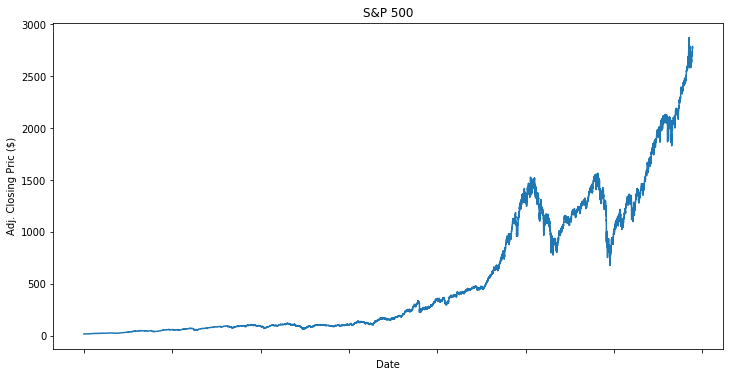

In [13]:
# Plotting the stock prices over time
df['Adj Close'].plot(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Adj. Closing Pric ($)')
plt.title('S&P 500')
plt.show()

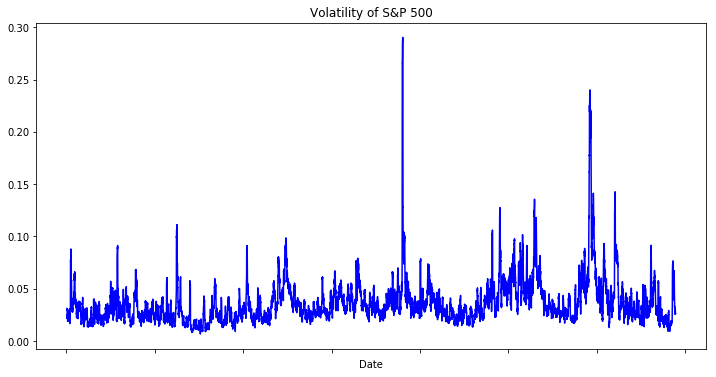

In [7]:
# compute and plot volatilty of stock price 
df['Log_Ret'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
plt.title('Volatility of S&P 500')
df['Volatility'] = df['Log_Ret'].rolling(20).std()*np.sqrt(20)
df['Volatility'].plot(color='blue',figsize=(12, 6))

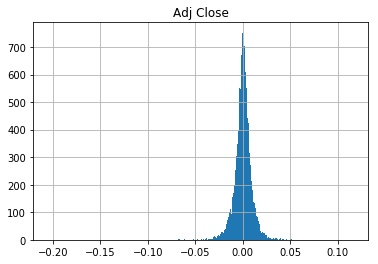

          Adj Close
count  17226.000000
mean       0.000343
std        0.009614
min       -0.204669
25%       -0.004029
50%        0.000468
75%        0.004961
max        0.115800


In [8]:
#compute daily returns

daily_close = df[['Adj Close']]
daily_pct_change = daily_close.pct_change()
daily_pct_change.fillna(0, inplace=True)
daily_log_returns = np.log(daily_close.pct_change()+1)

# Plot distribution of daily returns
daily_pct_change.hist(bins=500)
plt.show()

# print summary statistics
print(daily_pct_change.describe())

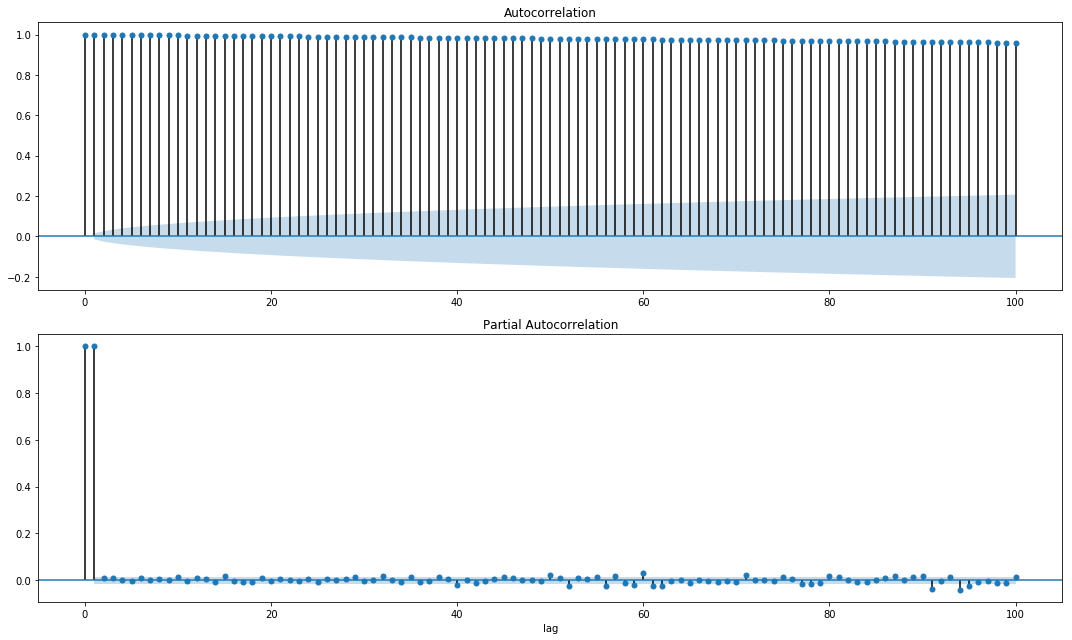

In [14]:
# plot autocorrelation
import statsmodels.api as sm

plt.figure(figsize=(15,9))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['Adj Close'].values.squeeze(),lags=100, ax=ax)
ax = plt.subplot(212)
plt.xlabel('lag')
sm.graphics.tsa.plot_pacf(df['Adj Close'].values.squeeze(),lags=100, ax=ax)
plt.tight_layout()
plt.show()

## 3. Benchmark model

In [15]:
split = 12000
series = df[['Adj Close']]
from sklearn import linear_model

#Preparation of data
series = df[['Adj Close']].reset_index()
x_bench = series.index.to_series().values
y_bench = series['Adj Close'].shift(-1).dropna().values
#Splitting data for testing and training
X_bench_train = x_bench[0:split].reshape(-1,1)
X_bench_test =  x_bench[split+1:len(series)-1].reshape(-1,1)
y_bench_train = y_bench[0:split].reshape(-1,1) 
y_bench_test = y_bench[split+1:len(series)].reshape(-1,1)

#Set up of Reggresor 
reg = linear_model.LinearRegression()
#Fitting the regressor
reg.fit(X_bench_train,y_bench_train)
#Maling predictions
prediction_bench = reg.predict(X_bench_test)
regression_train = reg.predict(X_bench_train)


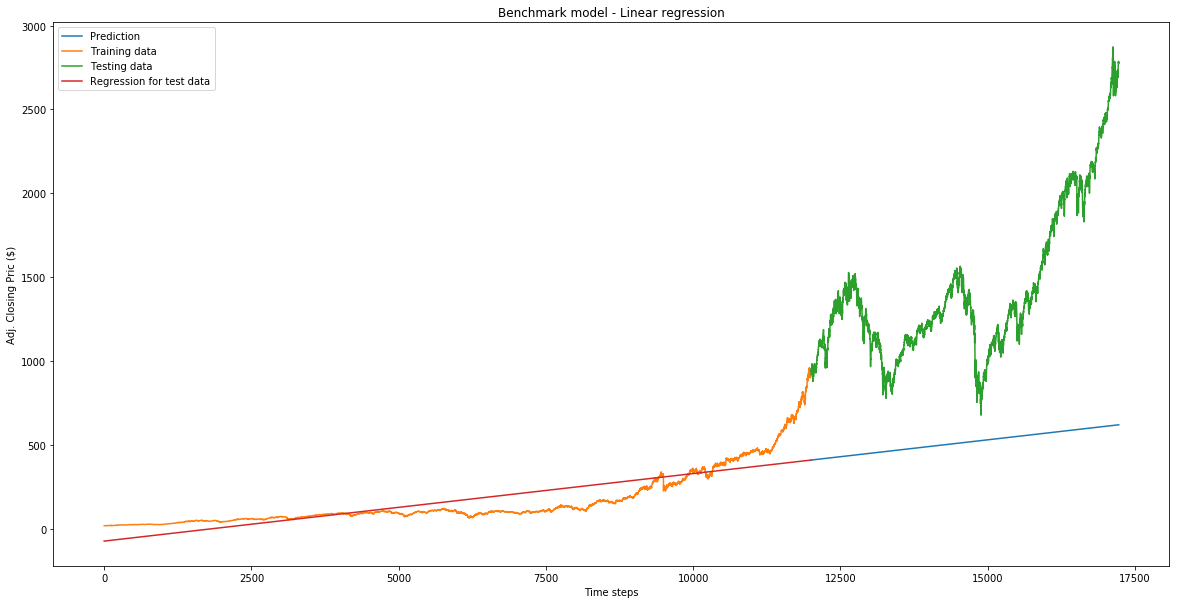

Mean squared error (for training data):  9647.05655868
Mean squared error (for prediction):  1017961.79261


In [16]:
#Plotting the Benchmark results
from sklearn.metrics import mean_squared_error as mse
plt.figure(figsize=(20,10))
plt.xlabel('Time steps')
plt.ylabel('Adj. Closing Pric ($)')
plt.title('Benchmark model - Linear regression')

plt.plot(X_bench_test, prediction_bench, label='Prediction')
plt.plot(X_bench_train, y_bench_train, label='Training data')
plt.plot(X_bench_test, y_bench_test, label='Testing data')
plt.plot(X_bench_train, regression_train, label='Regression for test data')
plt.legend()
plt.show()


#Calculation of the MSE
print ("Mean squared error (for training data): ", mse(y_bench_train, regression_train))
print ("Mean squared error (for prediction): ", mse(y_bench_test, prediction_bench))

## 4. Data preparation

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = dataset
window = 5
# Split data in training and testing set
split = 12000
data_train, data_test = data[0:split], data[split+1:len(data)]
#Smooth the data
rolling = data_train.rolling(5)
data_train = rolling.mean().dropna()
# Normalize the data
window_smooth = 2000
#Normalize training data in batches
for i in range(6):
    data_train[i*window_smooth:i*window_smooth+window_smooth] = scaler.fit_transform(data_train[i*window_smooth:i*window_smooth+window_smooth])
#Normalize testing data
data_test = scaler.fit_transform(data_test)
data_train = np.array(data_train)
# Unrolling data
def unrolling(data, step_size):
    data_X, data_Y = [], [] 
    for i in range(step_size, len(data)):
        data_X.append(data[i - step_size:i,4])
        data_Y.append(data[i,4])
    return np.array(data_X), np.array(data_Y)
x_train, Y_train = unrolling(data_train, window)
x_test, Y_test = unrolling(data_test, window)
# Reshape data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1 ))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1 ))

## 5. LSTM Modell

In [45]:
from sklearn.metrics import mean_squared_error as mse
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential;
from keras.callbacks import EarlyStopping
#build a sequential LSTM-model
model = Sequential()
model.add(LSTM(200,input_shape=(window,1), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(200,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(150,return_sequences=False))
model.add(Dropout(0.5))
#outputlayer
model.add(Dense(1,activation='linear'))
#compile the model
model.compile(loss='mse',optimizer='adam')
#fit the model
hist = model.fit(x_train, Y_train,batch_size=2500, epochs=100,callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=5, verbose=1)], validation_split=0.02)

Train on 11751 samples, validate on 240 samples
Epoch 1/100
11751/11751 [==============================] - 44s 4ms/step - loss: 0.1940 - val_loss: 0.1538
Epoch 2/100
11751/11751 [==============================] - 31s 3ms/step - loss: 0.0445 - val_loss: 0.0049
Epoch 3/100
11751/11751 [==============================] - 32s 3ms/step - loss: 0.0229 - val_loss: 0.0908
Epoch 4/100
11751/11751 [==============================] - 32s 3ms/step - loss: 0.0282 - val_loss: 0.0186
Epoch 5/100
11751/11751 [==============================] - 31s 3ms/step - loss: 0.0145 - val_loss: 0.0023
Epoch 6/100
11751/11751 [==============================] - 31s 3ms/step - loss: 0.0106 - val_loss: 0.0177
Epoch 7/100
11751/11751 [==============================] - 30s 3ms/step - loss: 0.0092 - val_loss: 0.0039
Epoch 8/100
11751/11751 [==============================] - 32s 3ms/step - loss: 0.0061 - val_loss: 0.0017
Epoch 9/100
11751/11751 [==============================] - 33s 3ms/step - loss: 0.0054 - val_loss: 0.003

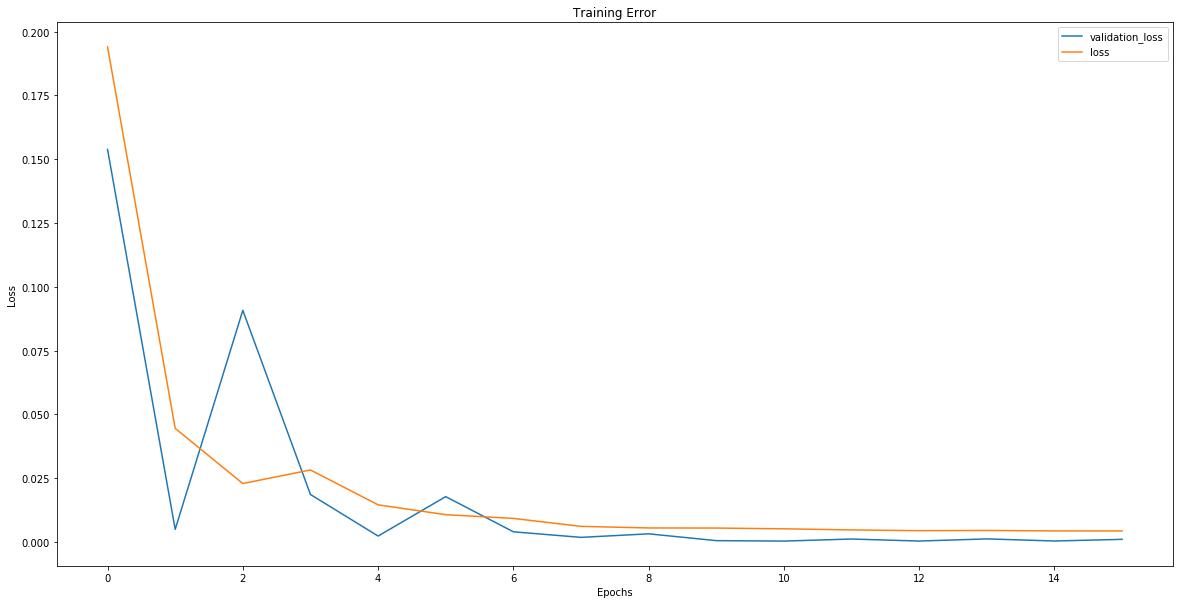

In [50]:
#plot training error
plt.figure(figsize=(20,10))
plt.plot(hist.history['val_loss'], label='validation_loss')
plt.plot(hist.history['loss'], label='loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Error')
plt.legend()
plt.show()

## 6. One day ahead predictions

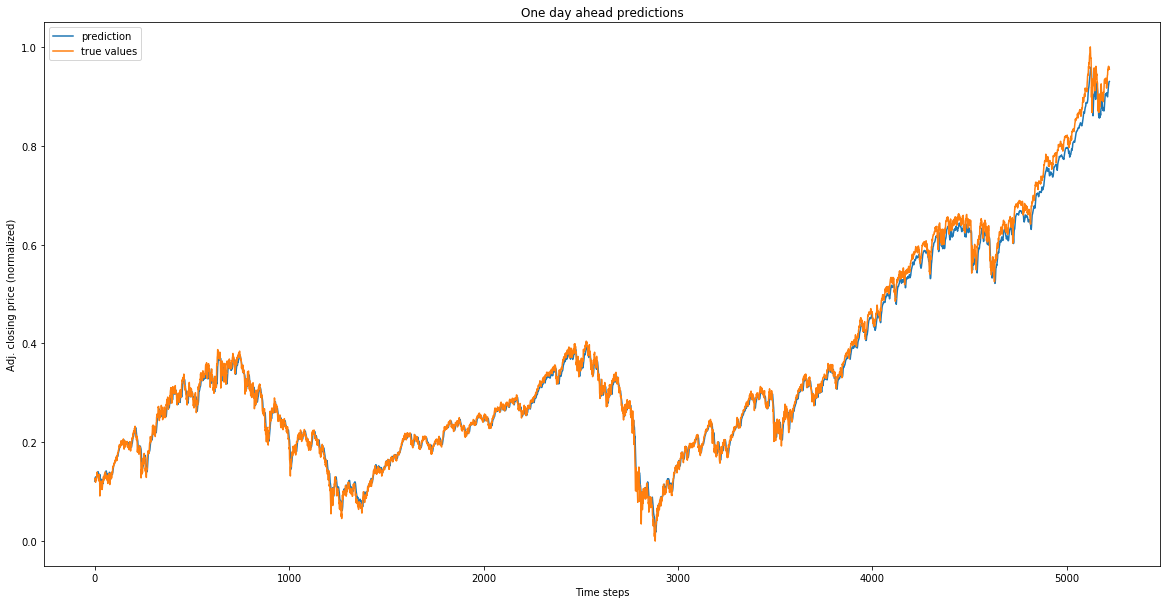

Mean squared error:  0.000235411633157


In [54]:
#preditions for a single day ahead
prediction = model.predict(x_test)
#plot predictions
plt.figure(figsize=(20,10))
plt.plot(prediction, label='prediction')
plt.plot(Y_test, label='true values')
plt.xlabel('Time steps')
plt.ylabel('Adj. closing price (normalized)')
plt.title('One day ahead predictions')
plt.legend()
plt.show()
#print mse
print ("Mean squared error: ", mse(Y_test, prediction))

## 6. Multiday predictions

In [55]:
#predict mutiple time steps ahead (Reference: http://www.jakob-aungiers.com/articles/a/LSTM-Neural-Network-for-Time-Series-Prediction)
def predictor_mult(x_test,model, window, prediction_seq,prediction_len):
    prediction_all =[]
    for i in range(prediction_seq):
        prediction_frame = x_test[i*prediction_len]       
        predictions = []
        for i in range(prediction_len):
            prediction = model.predict(np.array(prediction_frame).reshape(1,window,1))
            predictions.append(prediction)
            prediction_frame = prediction_frame[1:]
            prediction_frame = np.insert(prediction_frame, [window-1], predictions[-1], axis=0)
        prediction_all.append(predictions)
    return prediction_all



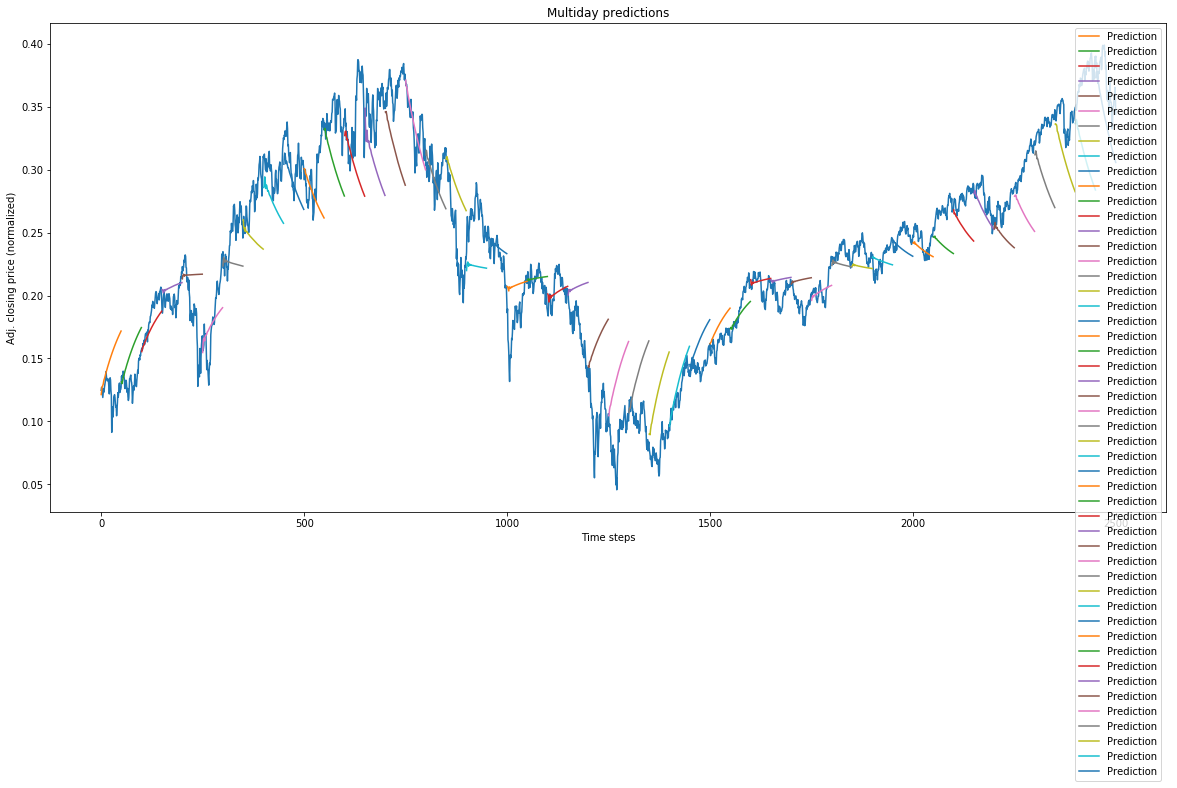

In [53]:
#Plot mutiple predictions (Reference: http://www.jakob-aungiers.com/articles/a/LSTM-Neural-Network-for-Time-Series-Prediction)

prediction_seq = 50 # how many many predictions squences should be done
prediction_len = 50 # how many time steps should one prediction have
prediction_all = predictor_mult(x_test,model, 5, prediction_seq,prediction_len)


fig = plt.figure(facecolor='white',figsize = (20,9))
ax = fig.add_subplot(111)
#plot true values 
ax.plot(Y_test[:prediction_seq*prediction_len])
#plot mutiple predictions
for i, data in enumerate(prediction_all):
    list = []
    for j in data:
        list.append(j[0])
    padding = [None for p in range(i * prediction_len)]
    plt.plot(padding+list, label='Prediction')
    plt.legend()
plt.xlabel('Time steps')
plt.ylabel('Adj. closing price (normalized)')
plt.title('Multiday predictions')
plt.show()




## 7. Free-Form Visualization

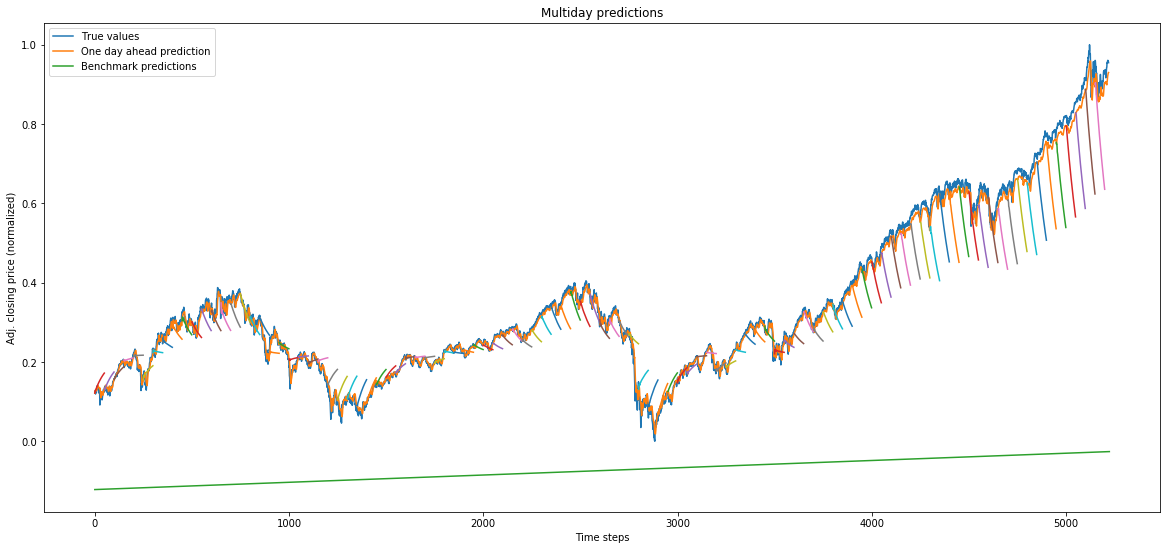

In [56]:
prediction_seq = 104 # how many many predictions squences should be done
prediction_len = 50 # how many time steps should one prediction have
prediction_all = predictor_mult(x_test,model, 5, prediction_seq,prediction_len)

fig = plt.figure(facecolor='white',figsize = (20,9))
ax = fig.add_subplot(111)
scaler = scaler.fit(y_bench_test)
prediction_bench_scaled = scaler.transform(prediction_bench)
#plot true values 
ax.plot(Y_test, label='True values')
#plot one day ahead predictions 
ax.plot(prediction, label='One day ahead prediction')
#plot benchmark predictions
ax.plot(prediction_bench_scaled, label='Benchmark predictions')
#plot multiday predictions
for i, data in enumerate(prediction_all):
    liste = []
    for j in data:
        liste.append(j[0])
    padding = [None for p in range(i * prediction_len)]    
    plt.plot(padding+liste)
plt.xlabel('Time steps')
plt.ylabel('Adj. closing price (normalized)')
plt.title('Multiday predictions')
plt.legend()
plt.show()


